# Energy Use

Analysing household energy use

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt# Import a scoring metric to compare methods

from datetime import timedelta, datetime

## Read Data

Consumption data downloaded from octopus. Different files for _historical_ and _latest_.

 - Historical are 9th August 2021 (the earliest data we have) until end of 8th August 2022 to make a good benchmark. 
 - Latest is from 9th August 2022 to present
 
Also add a cost column. Current prices are:
 - £0.075 from 00:30 - 04:30
 - £0.3882 all other times

In [16]:
# Precise times of historical data (not sure if this is needed)
start_historical = datetime.fromisoformat("2021-10-09 00:00:00+00:00")
end_historical   = datetime.fromisoformat("2021-10-08 23:59:59+00:00")

# A lookup with energy prices in half-hourly time slots
price_lookup = [0.3882] + [0.075] * 8 + [0.3882] * 39
assert len(price_lookup) == 48, f"{len(price_lookup)}"

def calc_cost(row):
    """Given a row of data, use the date (row index) and energy use to calculate the cost"""
    date = row.name # Stupidly the index is referenced using 'name' in pandas
    energy = row.energy
    # Find the cost for this half hourly slot. Multiply decimal hour by 2
    price_index = int( (date.hour + (date.minute / 60) ) * 2 )
    #print(date, price_index, ( date.hour + (date.minute / 60) ) * 2, price_lookup[price_index])
    return price_lookup[price_index]
    

def read_data(filename):
    """Process to read and clean data is the same for historical and latest datasets"""
    raw_data = pd.read_csv(os.path.join("data", filename))
    
    # Drop whitespace
    raw_data[' Start'] = raw_data[' Start'].apply(lambda x: x.strip())
    raw_data[' End'] = raw_data[' End'].apply(lambda x: x.strip())

    raw_data['energy'] = raw_data['Consumption (kWh)'] # Better column label

    # Create date objects
    # Do it properly, but the time offset is really annoying!
    #raw_data['StartDate'] = pd.to_datetime(raw_data[' Start'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    #raw_data['EndDate'] =  pd.to_datetime(raw_data[' End'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    # Ignore the time offset by splitting on the '+'
    raw_data['StartDate'] = raw_data[' Start'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )
    raw_data['EndDate']     = raw_data[' End'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )

    # Index is the start point for 30 minute interval
    #raw_data['Date'] = raw_data['StartDate']
    #raw_data = raw_data.set_index('Date')
    raw_data.index = pd.DatetimeIndex(raw_data.StartDate)
    raw_data.index.name = "Date"

    # Now just take the columns that we want
    raw_data = raw_data.loc[:,['energy']]
    
    # Add a cost column 
    raw_data['cost'] = raw_data.apply(calc_cost, axis=1)

    # Make some useful ones
    #df['Day'] = df.index.map(lambda x:x.day) # (had to do it this way before I had the DateTimeIndex set up properly)
    raw_data['day'] = raw_data.index.day
    raw_data['month'] = raw_data.index.month
    raw_data['year'] = raw_data.index.year
    raw_data['dayofyear'] = raw_data.index.dayofyear
    # Hour as a decimal
    #raw_data['hour'] = raw_data.index.map(lambda x:x.hour) + raw_data.index.map(lambda x:x.minute) / 60
    raw_data['hour'] =  raw_data.index.hour + (raw_data.index.minute / 60)
    # Season (thanks https://stackoverflow.com/questions/44124436/python-datetime-to-season)
    #[x%12 // 3 + 1 for x in range(13)]
    raw_data['season'] = raw_data.index.month%12 // 3 + 1
    return raw_data

hist_df = read_data("consumption-historical.csv.zip")
late_df = read_data("consumption-latest.csv.zip")

In [17]:
hist_df

,energy,cost,day,month,year,dayofyear,hour,season
Date,,,,,,,,
2021-10-09 00:00:00,0.074,0.3882,9,10,2021,282,0.0,4
2021-10-09 00:30:00,0.063,0.0750,9,10,2021,282,0.5,4
2021-10-09 01:00:00,0.040,0.0750,9,10,2021,282,1.0,4
2021-10-09 01:30:00,0.062,0.0750,9,10,2021,282,1.5,4
2021-10-09 02:00:00,0.064,0.0750,9,10,2021,282,2.0,4
...,...,...,...,...,...,...,...,...
2022-10-08 22:30:00,0.084,0.3882,8,10,2022,281,22.5,4
2022-10-08 23:00:00,0.080,0.3882,8,10,2022,281,23.0,4
2022-10-08 23:30:00,0.056,0.3882,8,10,2022,281,23.5,4


In [18]:
late_df

,energy,cost,day,month,year,dayofyear,hour,season
Date,,,,,,,,
2022-10-09 00:00:00,0.041,0.3882,9,10,2022,282,0.0,4
2022-10-09 00:30:00,0.062,0.0750,9,10,2022,282,0.5,4
2022-10-09 01:00:00,0.471,0.0750,9,10,2022,282,1.0,4
2022-10-09 01:30:00,0.293,0.0750,9,10,2022,282,1.5,4
2022-10-09 02:00:00,0.383,0.0750,9,10,2022,282,2.0,4
...,...,...,...,...,...,...,...,...
2023-01-14 21:30:00,0.835,0.3882,14,1,2023,14,21.5,1
2023-01-14 22:00:00,0.167,0.3882,14,1,2023,14,22.0,1
2023-01-14 22:30:00,0.113,0.3882,14,1,2023,14,22.5,1


Sanity checks

## Sanity check plots

Plot to check the data look sensible

Daily monthly totals

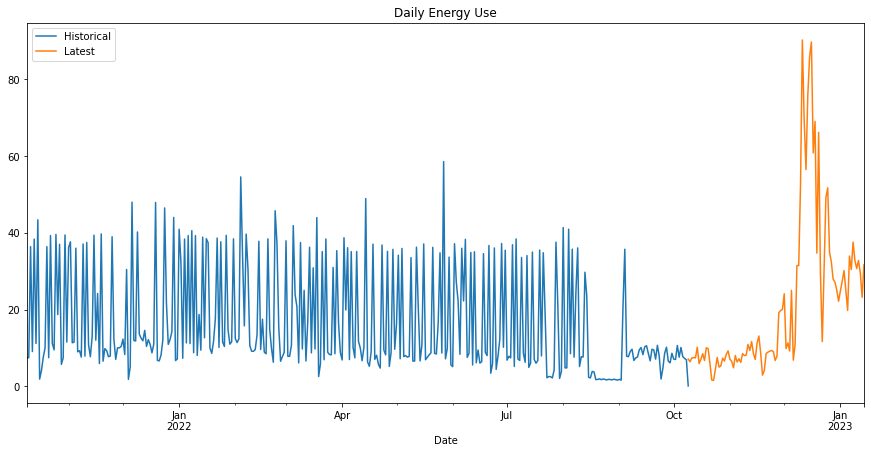

In [8]:
for (df, title) in [(hist_df, "Historical"), (late_df, "Latest")]: 
    df.groupby(df.index.floor('D'))['energy'].sum().plot(
        figsize=(15, 7), title=f"Daily Energy Use", legend=True, label=title)

Monthly totals

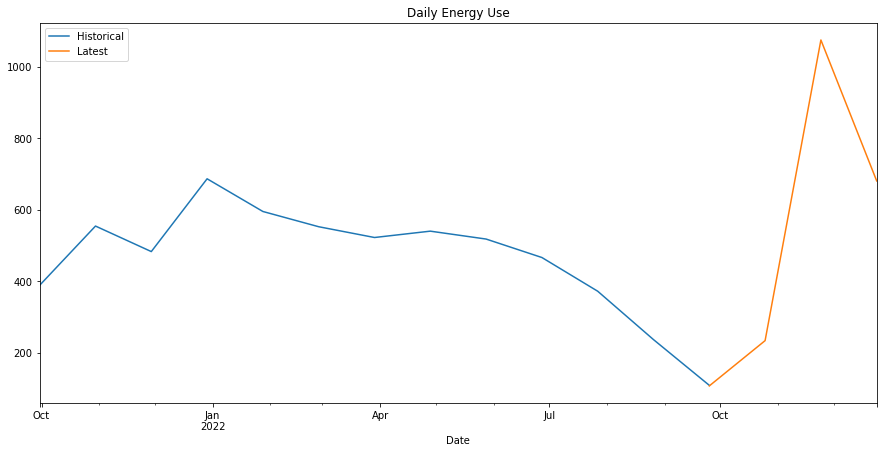

In [9]:
#floor(30D) gives 30 days; approx 1 month

for (df, title) in [(hist_df, "Historical"), (late_df, "Latest")]: 
    df.groupby(df.index.floor('30D'))['energy'].sum().plot(
        figsize=(15, 7), title=f"Daily Energy Use", legend=True, label=title)

One week in May, including cost

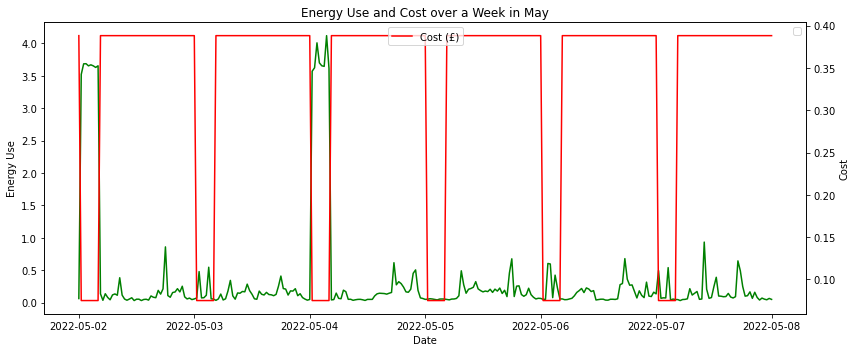

In [15]:
#temp = hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),]
temp = hist_df.loc[datetime.fromisoformat("2022-05-02"):datetime.fromisoformat("2022-05-08"),]

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Cost over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['cost'], color='red')
ax2.set_ylabel('Cost')
ax2.legend(['Cost (£)'], loc='upper center')

#ax.set_xticks(gdp['date'].dt.date)
#ax.set_xticklabels(gdp['date'].dt.year, rotation=90)
#ax.yaxis.grid(color='lightgray', linestyle='dashed')

plt.tight_layout()
plt.show()
#temp.plot(figsize=(15, 7), title="Energy over one week in may (for example)", legend=True, label="energy");
#hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),
#         'energy'].plot(figsize=(15, 7), title="Energy over one week in may (for example)");



Another short week in Dec (mostly to check daylight saving hasn't wrecked things, and to check the latest data)

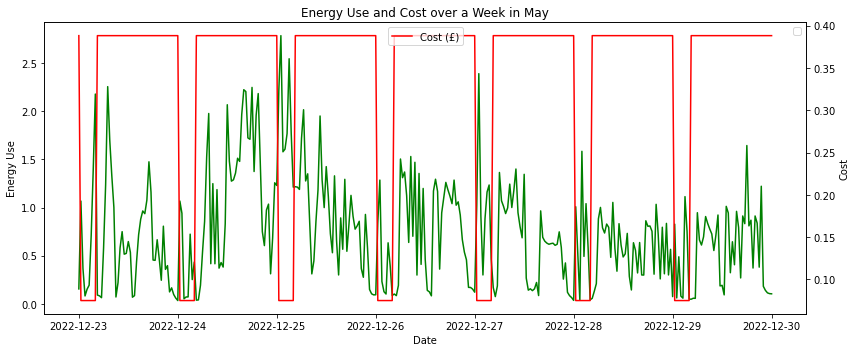

In [25]:
temp = late_df.loc[datetime.fromisoformat("2022-12-23"):datetime.fromisoformat("2022-12-30"),]

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Cost over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['cost'], color='red')
ax2.set_ylabel('Cost')
ax2.legend(['Cost (£)'], loc='upper center')

plt.tight_layout()
plt.show()

A day in Dec (so I can compare against a bill)

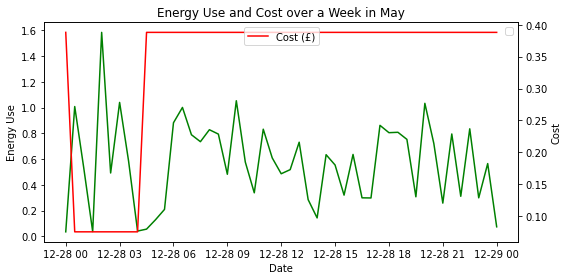

In [28]:
temp = late_df.loc[datetime.fromisoformat("2022-12-28"):datetime.fromisoformat("2022-12-29"),]

fig, ax = plt.subplots(figsize=(8,4))
ax2 = ax.twinx()

ax.set_title('Energy Use and Cost over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['cost'], color='red')
ax2.set_ylabel('Cost')
ax2.legend(['Cost (£)'], loc='upper center')

#ax.set_xticks(gdp['date'].dt.date)
#ax.set_xticklabels(gdp['date'].dt.year, rotation=90)
#ax.yaxis.grid(color='lightgray', linestyle='dashed')

plt.tight_layout()
plt.show()
#temp.plot(figsize=(15, 7), title="Energy over one week in may (for example)", legend=True, label="energy");
#hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),
#         'energy'].plot(figsize=(15, 7), title="Energy over one week in may (for example)");



## Create Averages

Want to estimate new costs after installing heat pump. Need to create some benchmarks. Average use for different days (e.g. weekday in winter, weekend in summer, etc...)